In [ ]:
import pandas as pd
import os
import seaborn as sns

# get data from xlsx file
def get_data_from_xlsx(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name=None)
    
    # Concatenate all sheets into a single DataFrame
    all_data = pd.concat(df.values(), ignore_index=True)
    
    return all_data
# get data from csv file

dataset_org = get_data_from_xlsx('credit_score_mn.xlsx')

In [4]:
def convert_loan_grade(loan_grade):

    a = loan_grade.split(": ")
    if len(a) < 2:
        value = a[0]
    else:
        value = a[1]

    value = int(ord(value) - int(ord('A')))
    return value 

dataset = dataset_org.copy()
dataset['Label_loan_grade'] = dataset['Label_loan_grade'].apply(convert_loan_grade)


test_dataset= dataset[-200:]
dataset = dataset[:-200]

XGBoost:
Accuracy: 0.92
MAE: 0.11
MSE: 0.16


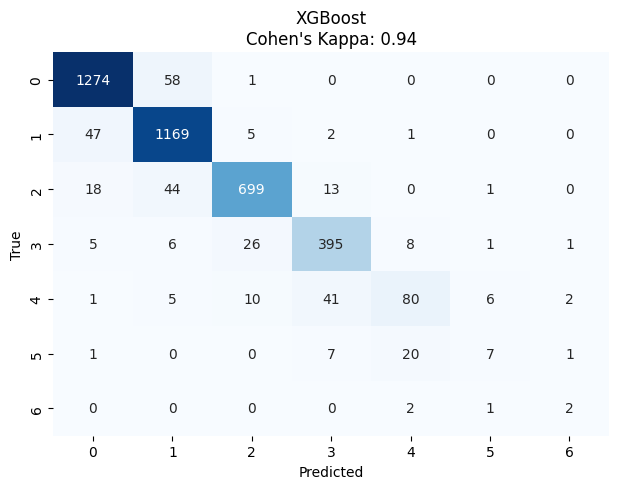

In [12]:

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
ds = dataset.copy()

contiuous_columns = [
    'loan_interest_rate',
    'person_age',
    'Зээлийн Оноо: Employment_length(in_years)',
    'loan_percent_income',
    'annual_person_income',
    'loan_amount',
    'Credit_history_length( max 10 )',

    # 'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    # 'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    # 'loan_status (0 is non default 1 is default)',
    # 'Historical_default(0=No,1=Yes)',
]

categorical_columns = [
    'Home_Ownership(0=Rent,1=Own,2=Mortgage,3=Other)',
    'loan_intent(0=Personal,1=Education,2=Medical,3=Venture,4=Home,5=DebtConsolidation)',
    'loan_status (0 is non default 1 is default)',
    'Historical_default(0=No,1=Yes)'
]

# drop columns that are not needed
X = ds.drop(columns=['Label_loan_grade'])
y = ds['Label_loan_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), contiuous_columns),  # Scale numerical columns
        ('cat', 'passthrough', categorical_columns)    # Leave categorical columns unchanged
    ])

# XGBoost with ordinal target

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('xgb', xgb.XGBClassifier(objective='reg:logistic', eval_metric='mae'))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)


print("XGBoost:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")

# Confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)


# Weighted Cohen's kappa (quadratic weights for ordinal errors)
kappa_xgb = cohen_kappa_score(y_test, y_pred_xgb, weights='quadratic')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'XGBoost\nCohen\'s Kappa: {kappa_xgb:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [11]:
td = test_dataset.copy()
y_pred_xgb = xgb_pipeline.predict(td)


# Print the predictions that failed
print("Failed predictions of 200 samples:")

for i, label in enumerate(y_pred_xgb):
    # add predictions to test_dataset
    td.loc[test_dataset.index[i], 'Predicted_Label_loan_grade'] = int(label)
    if label != td.loc[test_dataset.index[i], 'Label_loan_grade']:
        print(f"#{i} Predicted: {label}, Actual: {td.loc[test_dataset.index[i], 'Label_loan_grade']}")


td[['Label_loan_grade', 'Predicted_Label_loan_grade']].to_csv('predictions.csv', index=False)

Failed predictions of 200 samples:
#31 Predicted: 1, Actual: 3
#67 Predicted: 2, Actual: 1
#72 Predicted: 1, Actual: 2
#74 Predicted: 1, Actual: 0
#75 Predicted: 3, Actual: 4
#78 Predicted: 2, Actual: 3
#82 Predicted: 0, Actual: 3
#97 Predicted: 1, Actual: 3
#104 Predicted: 1, Actual: 0
#105 Predicted: 1, Actual: 2
#110 Predicted: 0, Actual: 1
#127 Predicted: 1, Actual: 2
#151 Predicted: 1, Actual: 0
#168 Predicted: 0, Actual: 1
#170 Predicted: 4, Actual: 3
#180 Predicted: 3, Actual: 5
